In [1]:
import os.path as path
import pandas as pd
import json
import srai.loaders.osm_way_loader as way
from scripts.data_downloader import download_city_tiles
from scripts.data_enricher import enrich_data
from scripts.geometry_manipulations import add_more_formats
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import contextily as cx

import geopandas as gpd

In [2]:
city_code = "Wrocław, PL"
zoom = 18
city_name = f"Wroclaw{zoom}"
osm_filter = { 'highway' : [
        "motorway",
        "motorway_link",
        "trunk",
        "trunk_link",
        "primary",
        "primary_link",
        "secondary",
        "secondary_link",
        "tertiary",
        "tertiary_link",
        "residential",
        "living_street",
    ]}
result_dir = path.join("data", "example")
city_dir = path.join(result_dir, city_name)

In [3]:
# gdf = download_city_tiles(city_code, city_name, zoom, osm_filter, result_dir)
# gdf = enrich_data(gdf, city_name, result_dir)
gdf = gpd.read_file(path.join(city_dir, "rich_gdf.geojson"))
gdf = gdf.set_index('id')
gdf = add_more_formats(gdf, city_name, result_dir)

Adding more data formats for Wroclaw18
Adding formats
Saving results


In [4]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

In [5]:
def get_token_size(row, column, tokenizer):
    if type(row[column]) == float or row[column] is None:
        return 0
    tokens = tokenizer.tokenize(json.dumps(row[column]))
    return len(tokens)
    
def get_wkt_token_size(row, column, tokenizer):
    if type(row[column]) == float or row[column] is None:
        return 0
    tokens = tokenizer.tokenize(row[column])
    return len(tokens)

In [6]:
gdf["tokens_geo"] = gdf.apply (lambda row: get_token_size(row, 'geojson',tokenizer), axis=1)
gdf["tokens_geo_s"] = gdf.apply (lambda row: get_token_size(row, 'simple',tokenizer), axis=1)
gdf["tokens_geovt"] = gdf.apply (lambda row: get_token_size(row, 'geojson_vt',tokenizer), axis=1)
gdf["tokens_geovt_s"] = gdf.apply (lambda row: get_token_size(row, 'simple_vt',tokenizer), axis=1)
gdf["tokens_wkt"] = gdf.apply (lambda row: get_wkt_token_size(row, 'wkt', tokenizer), axis=1)
gdf["tokens_wkt_s"] = gdf.apply (lambda row: get_wkt_token_size(row, 'simple_wkt', tokenizer), axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (2381 > 2048). Running this sequence through the model will result in indexing errors


In [7]:
geo_positive = gdf[gdf["hasGeo"]]

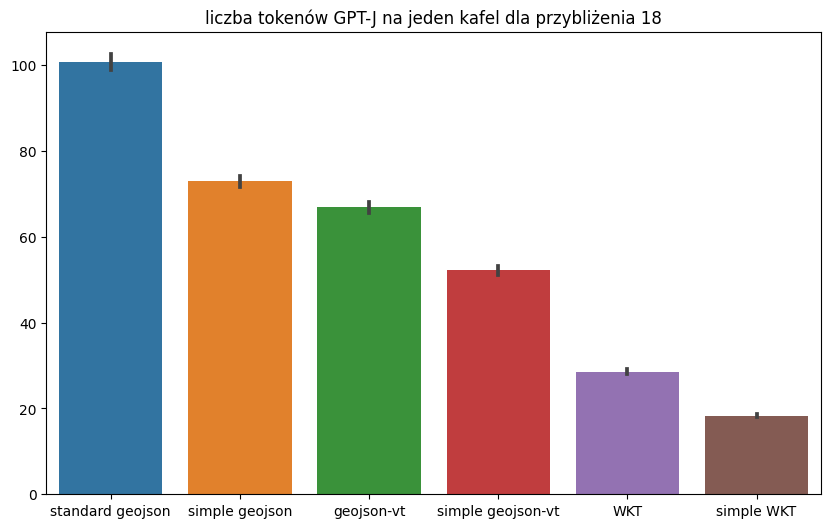

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# tokens_geo = [token_num for token_num in gdf['tokens_geo'] if token_num > 500]
# tokens_geovt = [token_num for token_num in gdf['tokens_geovt'] if token_num > 500]
# tokens_wkt = [token_num for token_num in gdf['tokens_wkt'] if token_num > 500]

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': gdf['tokens_geo'] , 'name': 'standard geojson'}),
    pd.DataFrame.from_dict({'value': gdf['tokens_geo_s'], 'name': 'simple geojson'}),
    pd.DataFrame.from_dict({'value': gdf['tokens_geovt'], 'name': 'geojson-vt'}),
    pd.DataFrame.from_dict({'value': gdf['tokens_geovt_s'], 'name': 'simple geojson-vt'}),
    pd.DataFrame.from_dict({'value': gdf['tokens_wkt'], 'name': 'WKT'}),
    pd.DataFrame.from_dict({'value': gdf['tokens_wkt_s'], 'name': 'simple WKT'})
])
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=df, y="value", x="name", ax=ax)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set(title=f"liczba tokenów GPT-J na jeden kafel dla przybliżenia {zoom}")
fig.savefig(f'tokeny{zoom}.png')
plt.show()
# fig, ax = plt.subplots()
# sns.histplot(
#     data=df, x='value', hue='name', multiple='dodge',
#     bins=10, ax=ax
# )

In [9]:
max_dict = {
    'standard geojson' : int(gdf['tokens_geo'].max()),
    'simple geojson' : int(gdf['tokens_geo_s'].max()),
    'geojson-vt' : int(gdf['tokens_geovt'].max()),
    'simple geojson-vt' : int(gdf['tokens_geovt_s'].max()),
    'WKT' : int(gdf['tokens_wkt'].max()),
    'simple WKT' : int(gdf['tokens_wkt_s'].max())
}
with open(f"max{zoom}.json", "w") as max_file:
    json.dump(max_dict, max_file)

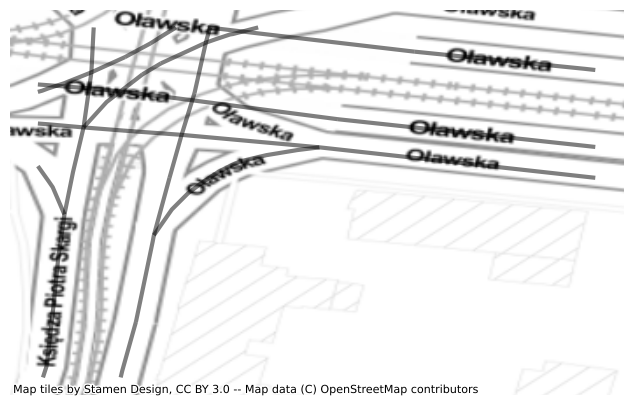

In [10]:
row = gdf.iloc[gdf['tokens_wkt'].argmax()]
complex_tile = gpd.GeoDataFrame.from_features(row['geojson']['features'], crs = 'EPSG:4326')
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = complex_tile.plot(ax = ax, alpha=0.5, edgecolor="k", linewidth=3)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=complex_tile.crs.to_string(), zoom = zoom)
ax.set_axis_off()
fig.savefig(f'complex_tile{zoom}.png')

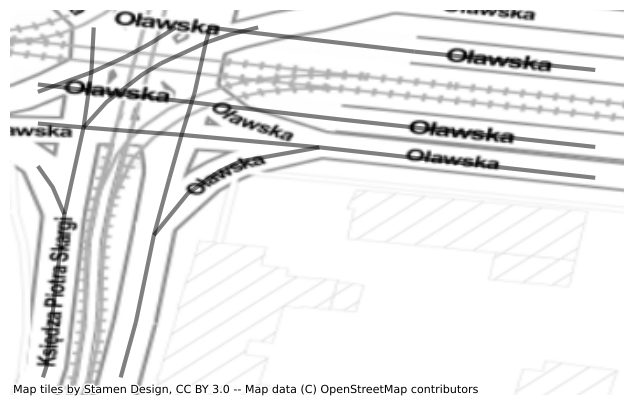

In [11]:
simple_tile = gpd.GeoDataFrame.from_features(row['simple']['features'], crs = 'EPSG:4326')
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = simple_tile.plot(ax = ax, alpha=0.5, edgecolor="k", linewidth=3)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=simple_tile.crs.to_string(), zoom = zoom)
ax.set_axis_off()
fig.savefig(f'simple_tile{zoom}.png')

In [12]:
print(row['tokens_wkt'])
print(row['tokens_wkt_s'])

715
591
